In [1]:
import sys
sys.path.append("/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/..")

from PIL import Image
import torch
# from models.model import MyModel


In [2]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}%"
    )

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from models.model import MyModel
# from torchinfo import summary
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_name="google/flan-t5-small",
    ffn=True,
    # transformer_model_name="google/flan-t5-base",
    transformer_d_model=768,
    transformer_d_ff=3072,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1000,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=256,
    max_target_length=256,
    # Train setting
    pretrain=True, 
    # Dir setting
    root_dir="/user/data",
    result_dir="results/",
)
model = MyModel(args).to(device)
print(model)
print_trainable_parameters(model)
# 読み込みたい重みのパスを指定
# path = "/home/tsuchida/KLab_MultiModalModel/results/pretrain_claa/imagenet/enc2_dec1/best.pth"
# model.load(result_name=path)
# model.eval()

MyModel(
  (language_model): T5EncoderModel(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=512, out_features=1024, bias=False)
                (wi_1): Linear(in_featur

#### logからLossとAcc曲線を書く

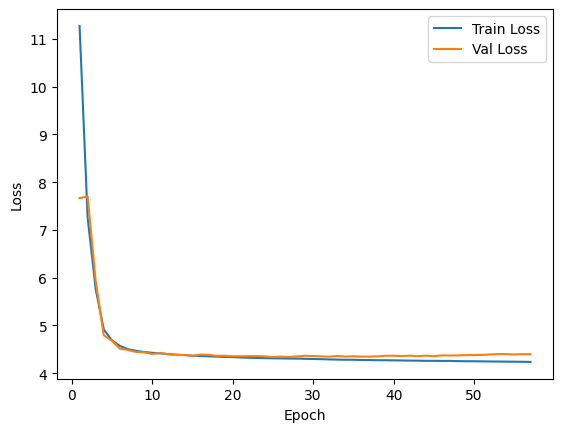

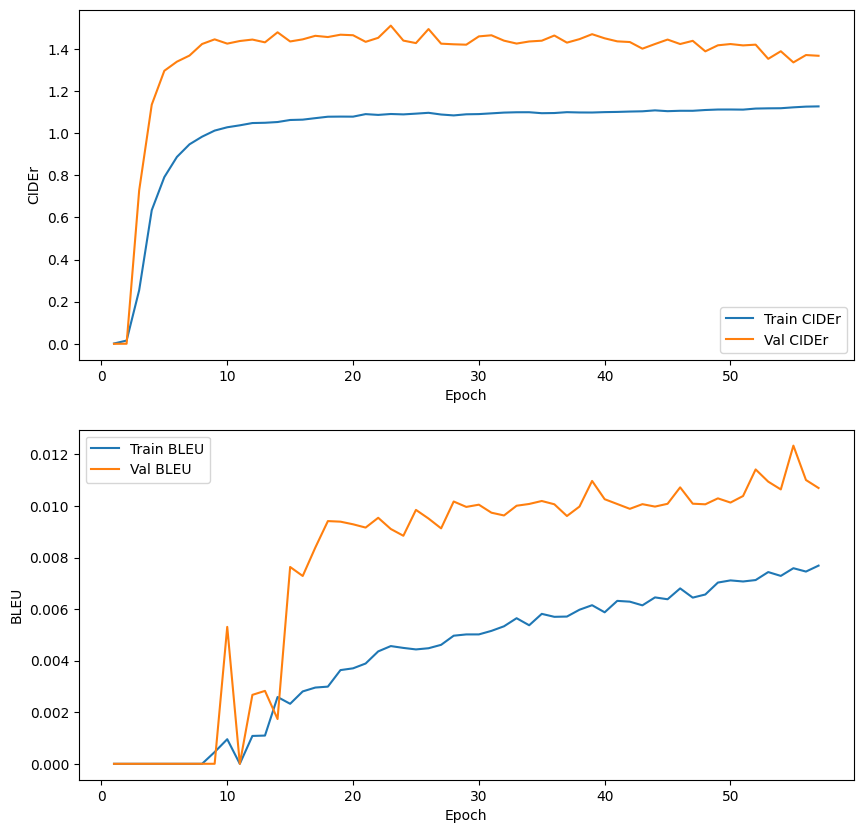

In [1]:
import re
import matplotlib.pyplot as plt

path = "/home/tsuchida/KLab_MultiModalModel/results/a100/freeze/cc3m/enc2_dec12/train.log"
path = "/home/tsuchida/KLab_MultiModalModel/results/a6000/cc3m/enc2_dec12/train.log"
# path = "/home/tsuchida/KLab_MultiModalModel/results/a100/lr/cc3m/enc2_dec12/train.log"
path = "/home/tsuchida/KLab_MultiModalModel/results/a6000/lr/cc3m/enc2_dec12/train.log"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/openimage/enc2_dec12/train.log"

# ログファイルを読み込む
with open(path, 'r') as f:
    lines = f.readlines()

# データを取得する
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_accs_bleu = []
val_accs_bleu = []

for line in lines:
    if "Epoch" in line:
        epoch_match = re.search(r'Epoch \((\d+)/', line)
        train_loss_match = re.search(r'Train loss : ([\d\.e\-]+)', line)
        val_loss_match = re.search(r'Val loss : ([\d\.e\-]+)', line)
        train_acc_match = re.search(r'Train cider : ([\d\.e\-]+)', line)
        val_acc_match = re.search(r'Val cider : ([\d\.e\-]+)', line)
        train_acc = re.search(r'Train bleu : ([\d\.e\-]+)', line)
        val_acc = re.search(r'Val bleu : ([\d\.e\-]+)', line)


        if epoch_match and train_loss_match and val_loss_match and train_acc_match and val_acc_match and train_acc and val_acc:
            epochs.append(int(epoch_match.group(1)))
            train_losses.append(float(train_loss_match.group(1)))
            val_losses.append(float(val_loss_match.group(1)))
            train_accs.append(float(train_acc_match.group(1)))
            val_accs.append(float(val_acc_match.group(1)))
            train_accs_bleu.append(float(train_acc.group(1)))
            val_accs_bleu.append(float(val_acc.group(1)))


# グラフを描画する
fig = plt.figure()

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
# plt.ylim(2.5, 5.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.plot(epochs, train_accs, label='Train CIDEr')
ax1.plot(epochs, val_accs, label='Val CIDEr')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('CIDEr')
ax1.legend()

ax2.plot(epochs, train_accs_bleu, label='Train BLEU')

ax2.plot(epochs, val_accs_bleu, label='Val BLEU')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('BLEU')
ax2.legend()

